# Outline

This notebook complements the blog post and is intended to cover the following:
- [Reproducing diarization pipelines](#reproducing-diarization-pipelines)
- [Comparing results](#comparing-results)
- [Deep dive and error analysis](#deep-dive-and-error-analysis)
- [Conclusion](#conclusion)
- [Score and analyze your own data](#score-and-analyze-your-own-data)
- [Appendix](#appendix)


# Reproducing diarization pipelines<a id='reproducing-diarization-pipelines'></a>

## Setup


If you have cloned the repro and are running this locally, make sure you first follow setup in `tdrz_dev/README.md`. This notebook handles the rest of the setup (including downloading eval data).

> *NOTE: If running on Google Colab - until we figure out how to get the fstalign scoring tool working there - this notebook will fetch pre-computed scored results. You can still run the error inspection and analysis sections.*

In [1]:
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython import display as ipd

In [2]:
if 'google.colab' in str(get_ipython()):
    # clone a particular branch of tinydiarize repo
    ! git clone https://github.com/akashmjn/tinydiarize.git
    # pip install
    ! pip install -e tinydiarize
    # setup workdir
    WORKDIR = 'tinydiarize/tdrz_dev/workdir_analysis'
    CODEDIR = 'tinydiarize/tdrz_dev'
    _PRE_COMPUTED = True
else:
    # if running locally, assume that tinydiarize repo is already cloned and setup
    WORKDIR = '../workdir_analysis'
    CODEDIR = '..'
    _PRE_COMPUTED = False

# _PRE_COMPUTED = True  # comment out if you want to just quickly step through analysis

ipd.clear_output()

In [4]:
# setup workdir structure and fetch evaluation data
if _PRE_COMPUTED:
    # download pre-computed results from blob
    ! wget -O {CODEDIR}/workdir_analysis.tar.gz https://sharedstorage7190.blob.core.windows.net/tinydiarize/precomputed/workdir_analysis-060823/24ce3e95e3d8d0b8efd4395d5f9e5f0dc07d5078cc5ec00aca6b4b61129fa5d5.tar.gz
    # compute the SHA256 hash of the downloaded file
    ! echo "SHA256 hash of downloaded file: $(sha256sum {CODEDIR}/workdir_analysis.tar.gz)"
    # unpack pre-computed results into WORKDIR
    ! tar -xzf {CODEDIR}/workdir_analysis.tar.gz -C {CODEDIR}
else:
    ! mkdir -p {WORKDIR}
    # call a bash script with WORKDIR as an environment variable and fetch eval data
    ! bash {CODEDIR}/scripts/fetch_earnings21_calls.sh {WORKDIR}

ipd.clear_output()

In [ ]:
# listen to an example file 
ipd.Audio(f'{WORKDIR}/audio/earnings21-4374910.mp3')

## Transcribing and scoring

We use the `run_pipelines.py` convenience script to transcribe and score the calls. It runs ASR (Whisper `small.en`) along with various diarization pipelines (explained in the following sections), scores them and parses detailed results into a single tsv file. Make sure you have completed the setup steps above and have an appropriate token file.

> *NOTE: On Google colab, we skip this step and use pre-computed results from my runs, as it's currently tricky to setup the fstalign scoring tool*

In [ ]:
if not _PRE_COMPUTED:
    # change directory to ../scripts
    %cd {CODEDIR}/scripts

    # process all the selected calls
    calls = [
        ("earnings21-4385939", 19),
        ("earnings21-4374910", 2),
        ("earnings21-4359971", 10),
    ]

    # iterate over calls and run the script run_pipelines.py
    for call_id, num_speakers in calls:
        # provide the oracle # speakers to pipelines that do clustering as we only evaluate local diarization i.e. segmentation
        ! python run_pipelines.py {WORKDIR}/audio/{call_id}.mp3 {WORKDIR}/fstalign_scoring/references/{call_id}-ref.nlp {WORKDIR}/transcripts --num_speakers {num_speakers} --hf_token_file "HF_TOK.txt"

    # change directory back to ../notebooks
    %cd {CODEDIR}/notebooks


# Comparing results<a id='comparing-results'></a>

## Evaluation data

We adopt the zero-shot evaluation scheme of Whisper, testing on a different dataset than the tinydiarize model was finetuned on (`AMI meetings`). This helps us get a more realistic estimate of real-world generalization vs the model's ability to fit `AMI meetings` dataset-specific quirks.

For ease of analysis (and keeping with the 'tiny' spirit 😉) I've chosen a biased subset of 3 earnings calls from [rev/earnings21](https://github.com/revdotcom/speech-datasets/blob/main/earnings21/earnings21-file-metadata.csv). These were selected with the following criteria:
- One interactive Q&A meeting (*939, Hershey) with a higher number of speaker switches and unique speakers
- One meeting (*910, Amex) that is a moderated Q&A between only 2 speakers
- One meeting (*971, Constellium) that comprises both a presentation and Q&A session, and is somewhere in between

| file_id | audio_length | company_name | sector | speaker_switches | speaker_switches / minute | unique_speakers |
|---------|--------------|--------------|--------|------------------|---------------------------|-----------------|
| 4385939 | 3049.832     | Hershey Company | Consumer Goods | 132 | 2.60 | 19 |
| 4374910 | 2028.536     | American Express Company | Financial | 56 | 1.66 | 2 |
| 4359971 | 3759.944     | Constellium | Industrial Goods | 116 | 1.85 | 10 |

## Information on metrics

Diarization typically uses either time-based metrics (e.g. DER measures % of time correctly attributed) or transcript-based metrics that compare the final transcript. 

I prefer to use transcript-based metrics as:
- It helps us see errors the way an end-user would i.e. [WYSIWYG](https://en.wikipedia.org/wiki/WYSIWYG).
- Analyzing errors in the semantic context of the conversation is much more intuitive, and helps us quickly get a sense of where we really need to focus.
- Tricky edge cases such as disfluencies, speaker overlap, etc. can be handled in an interpretable way via the transcription convention (e.g. using special tokens and/or text normalization).

In this notebook we focus on "local" diarization i.e. speaker segmentation (and not the "global" task of clustering speakers across the entire meeting). We use the following metrics for ease of interpretation and analysis:
- WER: word error rate as measured by `fstalign`
- Speaker turn recall: fraction of speaker changes that are correctly identified
- Speaker turn precision: fraction of predicted speaker changes that are correct

Just like WER, speaker turn recall and precision are computed by aligning reference and hypothesis transcripts after inserting a special `speaker__turn` token, and then counting errors on the special tokens. We also parse the aligned ref/hyp transcripts for error analysis. *(see implementation in `score.py` for details)*

## Compiling results

In [3]:
# some utility functions
%load_ext autoreload
%autoreload 2
import sys; sys.path.extend([CODEDIR, f"{CODEDIR}/notebooks"])
from analysis_utils import compile_results, summarize_results, query_metric_results, plot_metric_results, inspect_spk_errors

We compile all the TSV files generated by `run_pipelines.py` into a single dataframe for analysis. The dataframe contains both WER and speaker turn metrics along with a detailed error breakdown e.g. (DEL/INS/SUB) for WER, false negatives (DEL/SUB) for speaker turn recall, and false positives (INS/SUB) for speaker turn precision. 

We also parse a useful `*.sbs` file output by fstalign containing ref/hyp aligned with the errors. This is very helpful for error inspection and debugging.

In [4]:
results_all_df, analysis_results = compile_results(f"{WORKDIR}/fstalign_scoring/results")

Read 84 results from 21 files
Read 21 side-by-side analysis results


We compare the following approaches:
- `punctuation`: Simple baseline adding a speaker turn after every ending punctuation e.g. `.?!`. The recall of this baseline helps us get a sense for how well Whisper is already implicitly marking speaker turns (i.e. does it miss any). We hypothesize that the semantic context of a conversation is a strong signal for both punctuations and speaker turns.

- `pyannote_pre_sr`: Runs full pyannote diarization pipeline, and then whisper.transcribe on segments created by the pipeline, retaining the speaker assignment for each segment. [Pyannote](https://huggingface.co/pyannote/speaker-diarization) is a strong open-source baseline that runs dedicated 2-stage diarization models (segmentation + clustering).

- `segment_timestamped`: Simple baseline that separates every time segment created by Whisper (e.g. 00:27.080 --> 00:32.720 "this is a segment") with a speaker turn. Similar to `punctuation`, the recall of this simple baseline helps us get a rough upper bound for how well [clustering Whisper segments](https://huggingface.co/spaces/vumichien/Whisper_speaker_diarization) can do.

- `tdrz_token`: tinydiarize model introducing a new `speaker_turn` token in the vocabulary which is decoded in whisper.transcribe itself. It was finetuned on ~100hrs from the AMI meetings dataset prepared into long-form 30s chunks. Viewing this as a special case of punctuations, we'd expect this to have a much better precision than the `punctuation` baseline, with its recall as an upper bound. 

Our aim here is not to claim a new state of the art or anything but to (i) study whether Whisper already has a useful internal representation (ii) see how well we can extract that representation via a tiny finetuning budget (iii) see if we can retain original WER performance without overfitting to the finetuning dataset.

If it works, this approach has the advantage of much simpler and faster inference that can be easily integrated into optimized pipelines like [whisper.cpp](https://github.com/ggerganov/whisper.cpp).

Total # of words: 23630, Total # of speaker turns: 301


model                 small.en                                       
method             punctuation pyannote_pre_sr segment_timestamped   
metric                                                               
spk_turn_precision        19.5            83.4                14.5  \
spk_turn_recall           92.0            78.4                86.7   
wer_overall               10.9            12.9                10.9   
wer_speaker_switch        15.0            23.1                15.0   

model              small.en-tdrz  
method                tdrz_token  
metric                            
spk_turn_precision          97.7  
spk_turn_recall             70.8  
wer_overall                 10.3  
wer_speaker_switch          15.5

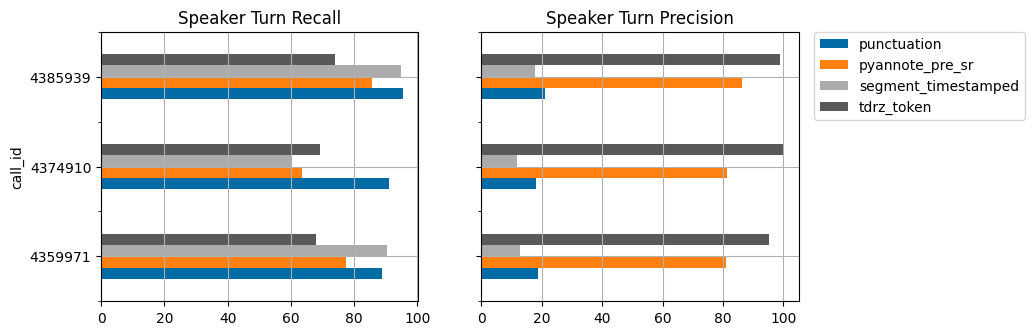

In [5]:
summary_df, results_df = summarize_results(results_all_df)
ipd.display(summary_df)

# plotting per-meeting speaker turn results
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)
d1 = query_metric_results(results_df, "spk_turn_recall", groups=["call_id", "method"])
plot_metric_results(d1, title="Speaker Turn Recall", ax=axes[0], legend=False)
d2 = query_metric_results(results_df, "spk_turn_precision", groups=["call_id", "method"])
plot_metric_results(d2, title="Speaker Turn Precision", ax=axes[1])

Going through the results, we can make the following observations:
1. The recall of the simple `punctuation` baseline is quite high i.e. it rarely misses punctuating a speaker turn. This validates our hypothesis that the model already has a good implicit representation of speaker turns via both acoustic and semantic cues (much like a punctuation).
2. The `pyannote_pre_sr` pipeline has the best all-round performance, but not as good recall or precision as the best individual methods. As we'll see in the next section, this is due to a design limitation that hinders its performance on short segments and quick speaker changes.
3. The recall of the `segment_timestamped` baseline is somewhat erratic compared to `punctuation`, with a big gap on call `*910`. I have also found it to be quite sensitive to other decoding parameters (e.g. previous_text_context). This aligns with common observations on the instability of Whisper timestamps.
4. The `tdrz_token` approach significantly improves precision over the punctuation baseline to almost 100%, while incurring some loss of recall. Strong performance with a very simple finetuning setup confirms that we can cheaply isolate representations that were already present in Whisper models.

In the next section, by manually inspecting errors we can build some intuition for the strengths and weaknesses of different approaches.

# Deep dive and error analysis<a id='deep-dive-and-error-analysis'></a>

## Error inspection

We now look through some examples to understand where the bottlenecks lie. Our choice of transcript-based metrics (speaker turn precision/recall) allows us to do this in a very interpretable way, by simply reading the aligned transcripts around speaker turn errors.

We will see that:
- Short segments (e.g. "yeah okay") and quick speaker changes are hard for `pyannote_pre_sr` because it uses acoustic embeddings to tell speakers apart locally. It is hard for even us to recognize a speaker from just a 1s audio clip - so the smaller the time unit, the worse the acoustic embeddings. This is a limitation of such approaches.
- Whisper can use the semantic context to make this problem much easier. Being trained to output punctuations helps it have a high recall on speaker turns, even in short segments.
- Finetuning `tdrz_token` to directly output speaker turns doesn't have as high recall as punctuations yet, although seems promising given the relatively cheap setup.
- Precision errors incurred by `pyannote_pre_sr` are also related to the short segment issue, where `tdrz_token` has a clear advantage.

In [6]:
# listen to an example file
call_id = "4385939"
ipd.Audio(f'{WORKDIR}/audio/earnings21-{call_id}.mp3')

### Recall errors: Short segments and importance of semantic context

We step through individual `recall_errors` below and have categorized them into the following types:

|Error type|pyannote_pre_sr|punctuation|tdrz_token|
|:----|:----|:----|:----|
|Recall|85%|95%|74%|
|# false negatives (out of 131)|19|6|34|
|invalid|2|2|4|
|ASR deletion|6|4|12|
|short segment|11|0|10|
|other segment|0|0|8|

#### pyannote_pre_sr (recall 85%):

Most of the errors (11) are around few-word short segments that are merged into surrounding ones. As discussed above, this is because of a design limitation of methods that only rely on acoustic information. *(the smaller the time unit, the worse the acoustic embeddings)*

> When we combine pyannote_pre_sr with whisper, it slightly increases recall errors (6 vs 4) because whisper deletes more words when it transcribes the segments cut by pyannote. See the Appendix for more details.

On reading through these errors ourselves, we can actually easily identify many of the speaker turns just from the semantic context even without listening to the audio.


In [34]:
# manually tagged errors:
# 0,7,8,10,11,13  - ASR deletion
# 1,2,3,6*,9,12,14,15,16,17,18  - short segment
# 4,5 - invalid (nonverbal speech)

# edit the list passed to recall_errors to inspect different error by tagged index
inspect_spk_errors(results_df, analysis_results, ("small.en", call_id, "pyannote_pre_sr"), recall_errors=[6])

Results for: ('small.en', '4385939', 'pyannote_pre_sr')
Precision: 86.15, # of false positives: 18
Recall: 85.50, # of false negatives: 19

 ---------- Spk turn recall errors: ----------

Line: 3263, Index: 6
                okay	okay                			
              thanks	thanks              			
                  so	so                  			
                much	much                			
                 for	for                 			
                 the	the                 			
               color	color               			
               there	there               			
       speaker__turn	speaker__turn       			
          absolutely	absolutely          			
       speaker__turn	<del>               	ERR	___41_SPEAKER_TURN___	41|
               thank	thank               			
                 you	you                 			
                 our	our                 			
                next	next                			
            question	question            			
               comes	comes               			

#### punctuation (recall 95%):

Due to availability of semantic context to Whisper's decoder, we see none of the short segment recall errors above. Whisper almost always places punctuations to demarcate different speakers. The only remaining errors are ASR deletions (similar to those seen above).

In [35]:
# manually tagged recall errors:
# 0,5 - invalid (nonverbal speech)
# 1,2,3*,4 - ASR deletion
inspect_spk_errors(results_df, analysis_results, ("small.en", call_id, "punctuation"), recall_errors=[3])

Results for: ('small.en', '4385939', 'punctuation')
Precision: 20.90, # of false positives: 473
Recall: 95.42, # of false negatives: 6

 ---------- Spk turn recall errors: ----------

Line: 6714, Index: 3
                  we	we                  			
                sell	sell                			
                  in	in                  			
              bricks	bricks              			
                 and	and                 			
              mortar	mortar              			
              steve-	<del>               			
       speaker__turn	speaker__turn       			
               right	<del>               			
               right	<del>               			
       speaker__turn	steve               	ERR	___84_SPEAKER_TURN___	84|
            anything	anything            			
                 you	you                 			
               <ins>	want                			
               wanna	to                  			
                 add	add                 			
       speaker__turn	speaker__turn       			
   

#### tdrz_token (recall 74%):

In an ideal case - we'd like to combine the high recall of the `punctuation` baseline, with a better precision as we assign a special token.

However we can see that there's still some room to improve on recall. No particular error type stands out, so it's possible that the current model favors precision over recall and will improve with a better finetuning setup.

In [7]:
# manually tagged recall errors:
# 0,1,23*,24,28,29,32*,33 - other segment 
# 5,15,16,17,18,19,22,27,30,31 - short segment
# 2,3,4,8,9,10,11,12,13,14,20,21 - ASR deletion
# 6,7,25,26 - invalid (nonverbal speech)
inspect_spk_errors(results_df, analysis_results, ("small.en-tdrz", call_id, "tdrz_token"), recall_errors=[32])

Results for: ('small.en-tdrz', '4385939', 'tdrz_token')
Precision: 98.98, # of false positives: 1
Recall: 74.05, # of false negatives: 34

 ---------- Spk turn recall errors: ----------

Line: 9385, Index: 32
                 the	the                 			
               floor	floor               			
                back	back                			
                  to	to                  			
                  ms	ms                  			
               poole	poole               			
                 for	for                 			
                 any	any                 			
               final	final               			
            comments	comments            			
       speaker__turn	<del>               	ERR	___129_SPEAKER_TURN___	129|
               thank	thank               			
                 you	you                 			
                 all	all                 			
                 for	for                 			
             joining	joining             			
                  us	us                  	

### Precision errors

Most precision errors for `pyannote_pre_sr` are because it can often split the audio into small overlapped segments that are not needed. These segments can either contain duplicate speech that is already in other segments or be false alarms. This happens more often when speakers change quickly, and is related to the time resolution design limitation discussed above.

Sometimes these overlapping segments are also written in the wrong order (serialization error), which is another problem. ([discussed later](#combining-pyannote-and-transcription-pipelines))

Meanwhile, the `tdrz_token` model has near 100% precision, showing that the extra `speaker_turn` token has quickly learned to be a strong indicator of speaker turns. This is a very promising result, as it shows that we can cheaply isolate behavior that was already present in Whisper models.

|Error type|pyannote_pre_sr|tdrz_token|
|:----|:----|:----|
|Precision|86%|99%|
|# predictions|130|96|
|# false positives|18|1|
|duplicate segment|3|0|
|extra segment|6|1|
|duplicate + serialization error|3|0|
|extra + serialization error|6|0|

In [37]:
# manually tagged precision errors:
# 0,8,11* - duplicate segment
# 1,2,4,5,6,17 - extra segment
# 3,7,12 - duplicate + serialisation
# 9,10,13,14,15,16 - extra segment + serialisation 

# in the example below there is a duplicate segment containing "really helpful"
inspect_spk_errors(results_df, analysis_results, ("small.en", call_id, "pyannote_pre_sr"), precision_errors=[11])

Results for: ('small.en', '4385939', 'pyannote_pre_sr')
Precision: 86.15, # of false positives: 18
Recall: 85.50, # of false negatives: 19

 ---------- Spk turn precision errors: ----------

Line: 4772, Index: 11
                  an	an                  			
                even	even                			
             greater	greater             			
              amount	amount              			
                  of	of                  			
             pricing	pricing             			
               power	power               			
       speaker__turn	speaker__turn       			
              really	really              			
             helpful	helpful             			
               <ins>	speaker__turn       	ERR		
               <ins>	really              			
               <ins>	helpful             			
               thank	thank               			
                 you	you                 			
                  so	so                  			
                much	much                			
       speaker__tur

In [8]:
# 0 - short extra segment
inspect_spk_errors(results_df, analysis_results, ("small.en-tdrz", call_id, "tdrz_token"))

Results for: ('small.en-tdrz', '4385939', 'tdrz_token')
Precision: 98.98, # of false positives: 1
Recall: 74.05, # of false negatives: 34


# Conclusion<a id="conclusion"></a>

In conclusion, we have shown that:

- Whisper models already have a good internal representation of speaker turns via both acoustic and semantic cues.
- Their placement of `punctuation` tokens appears to be very consistent with speaker turns (high recall).
- Whisper's time segments `segment_timestamped` (used for clustering [here](https://huggingface.co/spaces/vumichien/Whisper_speaker_diarization)) are less consistent.
- Acoustic embedding-based diarization methods like `pyannote_pre_sr` perform well overall, but struggle with short segments & quick speaker turns. This leaves a gap with the best individual precision or recall.
- `tdrz_token` shows that we can extract Whisper's speaker representations cheaply, and with small word error rate impact.
- With improvements to finetuning, strong performance can be expected as it can use both voice and semantic context to tell speakers apart, which is a unique benefit of this approach.

In [9]:
ipd.display(summary_df)

model                 small.en                                       
method             punctuation pyannote_pre_sr segment_timestamped   
metric                                                               
spk_turn_precision        19.5            83.4                14.5  \
spk_turn_recall           92.0            78.4                86.7   
wer_overall               10.9            12.9                10.9   
wer_speaker_switch        15.0            23.1                15.0   

model              small.en-tdrz  
method                tdrz_token  
metric                            
spk_turn_precision          97.7  
spk_turn_recall             70.8  
wer_overall                 10.3  
wer_speaker_switch          15.5

# Score and analyze your own data<a id="score-and-analyze-your-own-data"></a>

To do so, you will need to:
- Replace files under `WORKDIR/audio` with your own audio files
- Create reference files in the [fstalign NLP format](https://github.com/revdotcom/fstalign/blob/develop/docs/NLP-Format.md]) under `WORKDIR/fstalign_scoring/references` 
- Make sure that the NLP contains speaker IDs in column 2. These are only used to score speaker turns. If your transcript only has speaker turns without global IDs, you can just increment a dummy speaker ID after every turn.

Once this is done, you can simply plug it in to the `run_pipelines.py` script as above.

# Appendix<a id="appendix"></a>

In this section we go over some miscellaneous notes and observations that didn't fit in the main sections.

### Runtime comparison

These numbers were tested using the earnings21-4374910 call (33.8 min) on a Quadro RTX 5000 GPU. Whisper is run with beam_size=4 and condition_on_previous_text=True.

- The pyannote diarization pipeline takes an extra ~47% of transcription time. This includes 2 steps: local speaker segmentation + global clustering.
- To get an idea of the time taken for the global clustering step, I tested a naive clustering of Whisper produced segments (see `drz_post_sr` in `run_pipelines.py`). This is quite fast, taking only 3% of transcription time, implying that the segmentation step is likely the main bottleneck in pyannote.
- Lastly, we see that speaker segmentation done by `tdrz_token` is much cheaper, taking 8% extra transcription time. The extra time is a mix of the marginal cost of decoding extra `speaker_turn` tokens, and a couple of more hallucinations from the finetuned model.

|Stage|Runtime (s)|Extra cost (%)|
|:----|:----|:----|
|Whisper.transcribe|121.2|-|
|Pyannote diarization|56.6|47%|
|Clustering whisper segments|3.4|3%|
|Whisper.transcribe (tdrz)|131.5|8%|

### Impact of fine-tuning

While the overall numbers are similar - taking a closer look, we do see some differences in recognition WER (especially deletions).

In [10]:
cols = ["call_id", "model", "value", "deletions", "insertions", "substitutions"]
results_all_df.query("metric=='wer_overall' and method=='punctuation'")[cols].sort_values(["call_id", "model"])

,call_id,model,value,deletions,insertions,substitutions
0,4359971,small.en,12.074689,663,130,371
0,4359971,small.en-tdrz,14.579226,149,590,666
0,4374910,small.en,9.937005,322,41,126
0,4374910,small.en-tdrz,6.825107,53,99,184
0,4385939,small.en,10.298820,622,84,228
0,4385939,small.en-tdrz,7.543008,85,232,367


There is also a difference in the time segments i.e. `segment_timestamped`. Lower recall here implies that the model is producing longer time segments.

This is likely related to the nature of the finetuning data. Regularizing via more parameter-efficient finetuning methods might help avoid drastically changing the timestamp behavior.

In [11]:
cols = ["call_id", "model", "value", "deletions", "insertions", "substitutions"]
results_all_df.query("metric=='spk_turn_recall' and method=='segment_timestamped'")[cols].sort_values(["call_id", "model"])

,call_id,model,value,deletions,insertions,substitutions
3,4359971,small.en,90.434784,10,0,1
3,4359971,small.en-tdrz,74.782608,22,0,7
3,4374910,small.en,60.000004,19,0,3
3,4374910,small.en-tdrz,70.909088,15,0,1
3,4385939,small.en,94.656494,6,0,1
3,4385939,small.en-tdrz,80.152672,21,0,5


### Combining pyannote and transcription pipelines

For our analysis we chose to transcribe segments output by pyannote after serializing them into a single order. This removes any ambiguity in speaker assignment, however can have a few edge cases due to duplicate overlapped segments created by Pyannote that are serialized out of order as seen with "in your mind" below. This particularly impacts WER around speaker switches (15% -> 23% as seen above).

> For the serialization errors here, it is especially helpful to correlate precision errors with the original transcripts that contain timestamps. These can be found under `WORKDIR/transcripts/small.en/CALLID_drz_pre_sr/*.vtt`. 

![screenshot of transcript](duplicate-serialization.png)]

Both ASR and diarization could also be run totally indepedently. This way the original WER is not affected. But it requires combining the two with careful heuristic matching of timestamps to handle various overlap/extra/duplicate segment edge cases. The best example of this is [WhisperX](https://github.com/m-bain/whisperX) which currently adds a 3rd model to get word-level timestamps to help matching. I went with a simple approach for ease of illustration, although it should be possible to compare the two approaches as well.

*(as a sidenote, since reconciling duplicate/partially overlapped speech requires semantic information, I personally think it is cleanest and best done within the transcription pipeline itself as it has access to both acoustic and semantic information)*

### Extending with global clustering

Future work will explore extending segments produced by `tdrz_token` with global clustering. Here are some rough thoughts:
- As we saw above, creating embeddings + clustering a given set of segments is much faster than the segmentation step itself, so it will remain relatively "tiny" and efficient 😊.
- Since we're getting near-perfect precision from predicted speaker turns, they can actually be used as constraints during clustering as done in [Turn-to-Diarize](https://arxiv.org/abs/2109.11641).
- An early implementation of AHC-based clustering is in `drz_post_sr` in `run_pipelines.py`, although we'll likely want to use [NMESC](https://github.com/tango4j/Auto-Tuning-Spectral-Clustering). Contributions are welcome!